#train _test split(85% -15% )

In [1]:
import os
import shutil
from pathlib import Path
import random

random.seed(42)  # For reproducibility

source_dir = Path("../data/raw/COVID-19_Radiography_Dataset")
dest_dir = Path("../data/processed")
train_dir = dest_dir / "train_data_with_masks"
test_dir = dest_dir / "test_data_with_masks"

classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
split_ratio = 0.85

for cls in classes:
    print(f"Processing class: {cls}")
    
    # Paths to images and masks in raw data
    images_path = source_dir / cls / "images"
    masks_path = source_dir / cls / "masks"
    
    # List all image files (ignoring other file types)
    all_images = [img for img in os.listdir(images_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(all_images)

    split_index = int(len(all_images) * split_ratio)
    train_imgs = all_images[:split_index]
    test_imgs = all_images[split_index:]

    # Create train/test dirs for images and masks
    train_img_dir = train_dir / cls / "images"
    train_mask_dir = train_dir / cls / "masks"
    test_img_dir = test_dir / cls / "images"
    test_mask_dir = test_dir / cls / "masks"

    train_img_dir.mkdir(parents=True, exist_ok=True)
    train_mask_dir.mkdir(parents=True, exist_ok=True)
    test_img_dir.mkdir(parents=True, exist_ok=True)
    test_mask_dir.mkdir(parents=True, exist_ok=True)

    # Copy training images and masks
    for img in train_imgs:
        shutil.copy(images_path / img, train_img_dir / img)
        
        mask_file = masks_path / img
        if mask_file.exists():
            shutil.copy(mask_file, train_mask_dir / img)

    # Copy testing images and masks
    for img in test_imgs:
        shutil.copy(images_path / img, test_img_dir / img)
        
        mask_file = masks_path / img
        if mask_file.exists():
            shutil.copy(mask_file, test_mask_dir / img)

    print(f"  Copied {len(train_imgs)} images (and masks if any) to {train_img_dir}")
    print(f"  Copied {len(test_imgs)} images (and masks if any) to {test_img_dir}")


Processing class: Normal
  Copied 8663 images (and masks if any) to ..\data\processed\train_data_with_masks\Normal\images
  Copied 1529 images (and masks if any) to ..\data\processed\test_data_with_masks\Normal\images
Processing class: COVID
  Copied 3073 images (and masks if any) to ..\data\processed\train_data_with_masks\COVID\images
  Copied 543 images (and masks if any) to ..\data\processed\test_data_with_masks\COVID\images
Processing class: Lung_Opacity
  Copied 5110 images (and masks if any) to ..\data\processed\train_data_with_masks\Lung_Opacity\images
  Copied 902 images (and masks if any) to ..\data\processed\test_data_with_masks\Lung_Opacity\images
Processing class: Viral Pneumonia
  Copied 1143 images (and masks if any) to ..\data\processed\train_data_with_masks\Viral Pneumonia\images
  Copied 202 images (and masks if any) to ..\data\processed\test_data_with_masks\Viral Pneumonia\images


#augment minority and validation split, save train and val. npy file

In [ ]:
import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split

# --- Settings ---
data_dir = Path("../data/processed/train_data_with_masks")  # folder with subfolders per class, with images and masks
classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
img_size = (64, 64)

# Flags for optional behavior
flag_resize = True
flag_masks = True

# --- Load images and labels ---
X = []
y = []


print("Loading images and labels with optional mask application...")

for class_index, class_name in enumerate(classes):
    class_path = data_dir / class_name / "images"  # images are in a subfolder 'images'
    img_files = list(class_path.glob("*"))
    print(f"  Loading {len(img_files)} images from '{class_name}'")

    for img_path in img_files:
        # Load image with or without resizing
        if flag_resize:
            img = load_img(img_path, target_size=img_size, color_mode='grayscale')
        else:
            img = load_img(img_path, color_mode='grayscale')
        img_array = img_to_array(img)

        if flag_masks:
            # Construct mask path: same filename in 'masks' sibling folder
            mask_path = img_path.parent.parent / "masks" / img_path.name
            if mask_path.exists():
                if flag_resize:
                    mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
                else:
                    mask = load_img(mask_path, color_mode='grayscale')
                mask_array = img_to_array(mask) / 255.0  # Normalize mask to 0-1
                img_array = img_array * mask_array  # Apply mask
            else:
                print(f"Mask not found for {img_path.name}, skipping mask application.")

        X.append(img_array)

        # Create one-hot encoded label
        label = np.zeros(len(classes))
        label[class_index] = 1
        y.append(label)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
print(f"Total images loaded: {len(X)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Normalize images to [0,1]
X /= 255.0

# Identify minority class samples (all except 'Normal')
normal_mask = np.argmax(y, axis=1) == 0  # Index 0 is Normal
minority_mask = ~normal_mask

X_minority = X[minority_mask]
y_minority = y[minority_mask]
print(f"Minority class samples: {len(X_minority)}")

# Data Augmentation for minority classes
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_minority)

batch_size = len(X_minority)
augmented_iter = datagen.flow(
    X_minority,
    y_minority,
    batch_size=batch_size,
    shuffle=False
)
augmented_minority = next(augmented_iter)
print(f"Augmented minority samples generated: {len(augmented_minority[0])}")

# Combine original and augmented data
X_balanced = np.concatenate([X, augmented_minority[0]], axis=0)
y_balanced = np.concatenate([y, augmented_minority[1]], axis=0)
print(f"Total samples after augmentation: {len(X_balanced)}")

# Split into train and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_balanced,
    y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced.argmax(axis=1)
)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


# Save arrays as .npy files
np.save('X_traindl_with_masks.npy', X_train)
np.save('y_traindl_with_masks.npy', y_train)
np.save('X_valdl_with_masks.npy', X_val)
np.save('y_valdl_with_masks.npy', y_val)

print("Saved train and validation datasets as .npy files.")

# loaded each image from your dataset.
#If flag_masks was True, for every image:
#we looked for a corresponding mask in the masks/ directory.
#If the mask existed, we:
#Loaded and resized the mask.
#Multiplied the mask with the image, effectively applying it (masking out unwanted pixels).
#Then we:
#Collected the masked images into X.
#Applied data augmentation only to the minority classes (all except 'Normal').
#Combined original + augmented data.
#Split into training and validation sets.
#Saved them as .npy files.-images grayscale,normalised,masked


Loading images and labels with optional mask application...
  Loading 8663 images from 'Normal'
  Loading 3073 images from 'COVID'
  Loading 5110 images from 'Lung_Opacity'
  Loading 1143 images from 'Viral Pneumonia'
Total images loaded: 17989
X shape: (17989, 64, 64, 1), y shape: (17989, 4)
Minority class samples: 9326
Augmented minority samples generated: 9326
Total samples after augmentation: 27315
Training samples: 21852, Validation samples: 5463
Saved train and validation datasets as .npy files.


#test npy file

In [4]:
import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Settings ---
test_data_dir = Path("../data/processed/test_data_with_masks")
classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
img_size = (64, 64)

flag_resize = True
flag_masks = True

X_test = []
y_test = []

print("Loading test images and labels with optional mask application...")

for class_index, class_name in enumerate(classes):
    class_img_dir = test_data_dir / class_name / "images"
    img_files = list(class_img_dir.glob("*"))
    print(f"  Loading {len(img_files)} images from test class '{class_name}'")

    for img_path in img_files:
        # Load image (resized if flag is set)
        if flag_resize:
            img = load_img(img_path, target_size=img_size, color_mode='grayscale')
        else:
            img = load_img(img_path, color_mode='grayscale')
        img_array = img_to_array(img)

        # Optional mask application
        if flag_masks:
            mask_path = img_path.parent.parent / "masks" / img_path.name
            if mask_path.exists():
                if flag_resize:
                    mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
                else:
                    mask = load_img(mask_path, color_mode='grayscale')
                mask_array = img_to_array(mask) / 255.0
                img_array = img_array * mask_array
            else:
                print(f"Mask not found for {img_path.name}, skipping mask application.")

        X_test.append(img_array)

        # Create one-hot label
        label = np.zeros(len(classes))
        label[class_index] = 1
        y_test.append(label)

# Convert to numpy arrays
X_test = np.array(X_test, dtype=np.float32) / 255.0
y_test = np.array(y_test, dtype=np.float32)

print(f"Total test images loaded: {len(X_test)}")
print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

# Save test data
np.save('X_testdl_with_masks.npy', X_test)
np.save('y_testdl_with_masks.npy', y_test)

print("Saved test datasets as .npy files.")


Loading test images and labels with optional mask application...
  Loading 1529 images from test class 'Normal'
  Loading 543 images from test class 'COVID'
  Loading 902 images from test class 'Lung_Opacity'
  Loading 202 images from test class 'Viral Pneumonia'
Total test images loaded: 3176
Shape of X_test: (3176, 64, 64, 1), Shape of y_test: (3176, 4)
Saved test datasets as .npy files.


#Display a Few Images

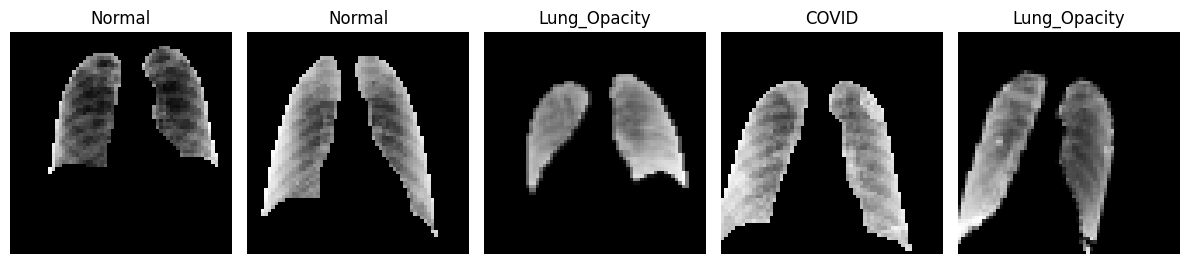

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved training data
X_train = np.load('X_traindl_with_masks.npy')
y_train = np.load('y_traindl_with_masks.npy')

# Function to display a few images with labels
def show_images(X, y, num_images=5):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        image = X[i].squeeze()  # remove channel if (64, 64, 1)
        label_index = np.argmax(y[i])
        label_names = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
        plt.imshow(image, cmap='gray')
        plt.title(label_names[label_index])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show a few sample images
show_images(X_train, y_train, num_images=5)
